In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vector
import pandas as pd
import lhapdf
import itertools

## General code for calculating polarization vector

In [90]:
# Tau mass
mtau = 1.77682 # GeV

def polarization_vector(tau4m, nu4m, nucleon4m, int_type: str, charm=None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    # I might also pass this as a parameter. Though probably not, since the model assumes that it is a nucleon, not a nucleus.
    Q2 = -q**2
    assert np.all(Q2 > 0), Q2

    W2 = (p + q)**2
    assert np.all(W2 > 0), W2
    
    x = Q2 / (2*p.dot(q)) # Björken scaling variable
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1)
        W2 = Wnres(x, Q2, p, q, M, 2)
        W3 = Wnres(x, Q2, p, q, M, 3)
        W4 = Wnres(x, Q2, p, q, M, 4)
        W5 = Wnres(x, Q2, p, q, M, 5)
    elif int_type == "dis":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        W1 = W1dis(x, Q2, p, q, M, charm)
        W2 = W2dis(x, Q2, p, q, M, charm)
        W3 = W3dis(x, Q2, p, q, M, charm)
        W4 = W4dis(x, Q2, p, q, M, charm)
        W5 = W5dis(x, Q2, p, q, M, charm)
    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    R = (
        (Etau - ptau * costheta) / M * (W1 + mtau / (2*M**2)*W4)
        + (Etau + ptau * costheta) / (2*M) * W2
        + ((Enu + Etau) / M * (Etau - ptau * costheta) / (2*M) - mtau**2 / (2*M**2)) * W3
        - mtau**2 / (2*M) * W5
    )

    return (
        # P_P component, in the tau-nu plane
        mtau * np.sin(theta) / (2*M*R) * (
            -(2*W1 - W2 - mtau**2/M**2 * W4 + Etau/M * W5) - Enu / M * W3 # X in lepton polarization paper, eq 7a
        ),
        # P_L component
        -1 + mtau**2/(M**2 * R) * (
            (2*M/(Etau + ptau) * W1 + (Etau - ptau) / (Etau + ptau) * W3) * np.cos(theta/2)**2
            + (M/(Etau + ptau) * W2 + (Etau + ptau) / M * W4 - W5) * np.sin(theta/2)**2
        ),
    )

In [18]:
# Cabbibo angle, from https://en.wikipedia.org/wiki/Cabibbo%E2%80%93Kobayashi%E2%80%93Maskawa_matrix
theta_c = 13.02 * np.pi/180 # radians
#
M_V = 0.84 # GeV
# difference between muon and electron magnetic moments (I think, see tau polarization paper)
xi = 3.706
# 
M_A = 1 # GeV
#
F_A_0 = -1.23
# Pion mass
m_pi = 0.139 # GeV


def w(p, q, M):
    return p.dot(q)/M**2

def G_V_E(q):
    return 1 / (1-q**2/M_V**2)**2

def G_V_M(q):
    return (1+xi) / (1-q**2/M_V**2)**2

def F_V(q, M):
    return (G_V_E(q) - q**2 / (4*M**2) * G_V_M(q)) / (1 - q**2 / (4*M**2))

def F_M(q, M):
    return (G_V_M(q) - G_V_M(q)) / (xi * (1 - q**2 / (4*M**2)))

def F_A(q):
    return F_A_0 / (1 - q**2 / M_A**2)**2

def F_T(q):
    return 0

def F_S(q):
    return 0

def F_p(q, M):
    return 2*M**2 * F_A(q) / (m_pi**2 - q**2)

def Wqel_coefficient(p, q, M):
    return np.cos(theta_c)**2 * 1/w(p, q, M) 

def W1qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_A(q)**2 + xprime * (F_A(q)**2 + (F_V(q, M) + F_M(q, M))**2))
    )

def omega_2(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return F_V(q, M)**2 + F_A(q)**2 + xprime * (F_M(q, M)**2 + 4*F_T(q)**2)

def W2qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * omega_2(x, Q2, p, q, M)
    )

def W3qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * -2 * np.real(np.conj(F_A(q)) * (F_V(q, M) + F_M(q, M)))
    )

def W4qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        # omega_4
        * (
            np.real(np.conj(F_V(q, M)) * (F_S(q) - 1/2 * F_M(q, M)) - np.conj(F_A(q)) * (F_T(q) + F_p(q, M)))
            + xprime * (1/2 * (F_M(q, M) - F_S(q))**2 + (F_T(q) + F_p(q, M))**2)
            - 1/4* (1+xprime) * F_M(q, M)**2 + (1+1/2 * xprime) * F_S(q)**2
        )
    )

def W5qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (
            2 * np.real(np.conj(F_S(q)) * (F_V(q, M) - xprime*F_M(q, M)) - np.conj(F_T(q)) * (F_A(q) - 2*xprime*F_p(q, M)))
            + omega_2(x, Q2, p, q, M)
        )
    )

In [5]:
particle_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_particles.csv")
event_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_event_info.csv")

In [5]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
taus = qel_particles[qel_particles["pdg"] == 15]
nus = qel_particles.groupby("event_num").nth(1)
assert np.all(nus["pdg"] == 16)
nucleons = qel_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [6]:
nutaus = qel_particles.groupby("event_num").nth(1).reset_index(drop=True)
assert (nutaus["pdg"] == 16).all()
taus = qel_particles.groupby("event_num").nth(2).reset_index(drop=True)
assert (taus["pdg"] == 15).all()

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

# delta-function, where x must be 1. To get this, we adjust the mass of the nucleon
M = np.ones(len(q.E)) * 0.938919 # GeV
# TODO change this to use W instead, so that the "real" nucleon mass is used
# M = -q**2 / (2*q.E)
nucleon4m = vector.array({"E": M, "px": np.zeros(M.shape), "py": np.zeros(M.shape), "pz": np.zeros(M.shape)})
# x = -q**2 / (2*nucleon4m.dot(q))
# assert np.allclose(x, 1), x

In [15]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(polarization_vector(vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), "qel"))

# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s), tau4m[zero_angle_tau_event].E

(array([[-0.0044405 ],
        [-0.99388519]]),
 0.9938951069298484,
 array([-0.99999002]),
 19.915222305224336)

In [8]:
# s = np.array(spin_vector(tau4m, nu4m, nucleon4m, "qel"))
# # The polarization (second term) should be slightly less than 1
# # See center left panel, figure 6 in tau polarization paper
# s, np.linalg.norm(s)*2

The values above are really good and close to what they should be. Let us now check $\theta = 5^\circ, 10^\circ$, since these are reproduced in the paper as well.

In [16]:
almost5deg = np.abs(tau_angles * 180/np.pi - 5).argmin()
tau_angles.iloc[almost5deg] * 180/np.pi, taus.iloc[almost5deg]["E"]

(4.99753678141035, 18.34137117931537)

In [17]:
s = np.array(
    polarization_vector(
        vector.MomentumNumpy4D(tau4m[almost5deg]), 
        vector.MomentumNumpy4D(nutau4m[almost5deg]), 
        vector.MomentumNumpy4D(nucleon4m[almost5deg]),
        "qel"
    )
)

# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-0.17783253],
        [-0.98965618]]),
 1.0055067233850195,
 array([-0.98423627]))

In [18]:
tau_deg = tau_angles * 180/np.pi 
# Select the event with the highest energy tau and a tau angle between 9.9 and 10.1 degrees
almost10deg = taus[((9.9 < tau_deg) & (tau_deg < 10.1)).values]["E"].idxmax()

s = np.array(
    polarization_vector(
        vector.MomentumNumpy4D(tau4m[almost10deg]), 
        vector.MomentumNumpy4D(nutau4m[almost10deg]), 
        vector.MomentumNumpy4D(nucleon4m[almost10deg]),
        "qel"
    )
)

# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-0.35464094],
        [-0.96195915]]),
 1.025249040848961,
 array([-0.93826876]))

In [19]:
taus.iloc[almost10deg, :]

event_num    38221.000000
pdg             15.000000
E               14.124795
px              -2.434212
py               0.106516
pz              13.799131
polx             0.007601
poly             0.173716
polz            -0.984766
Name: 2331, dtype: float64

There is something wrong with the code still. Here, the polarization value should be much higher and the angle should be closer to -1.

### Calculate polarization for all qel events

In [20]:
W2 = (nucleon4m + nutau4m - tau4m)**2

s = polarization_vector(
    tau4m[W2 > 0], 
    nutau4m[W2 > 0], 
    nucleon4m[W2 > 0],
    "qel"
)

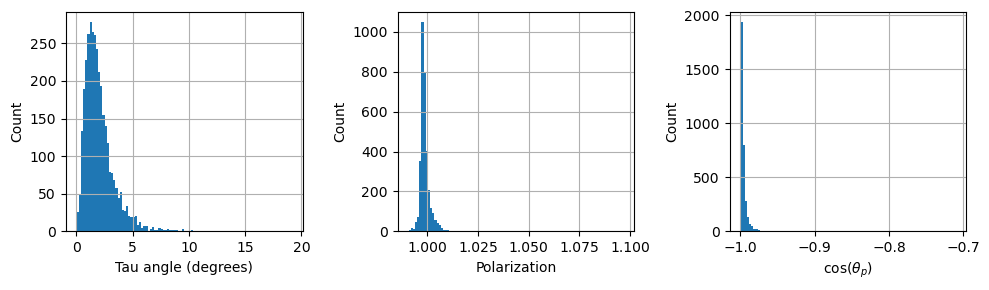

In [21]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(np.linalg.norm(s, axis=0), bins=100)
axs[1].set(xlabel="Polarization", ylabel="Count")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for a in axs:
    a.grid()
    # a.set_yscale("log")

In some cases, I get a polarization vector that has magnitude > 1. Though this might not be completely incorrect, since the equations are not perfect and there might be some assumptions here and there that I break (e.g., they might always assume that the nucleon mass is 0.938 GeV, whereas that is not true and that is not the value that I pass to the code).
If $|s| > 1$, I can simply normalize the vector.

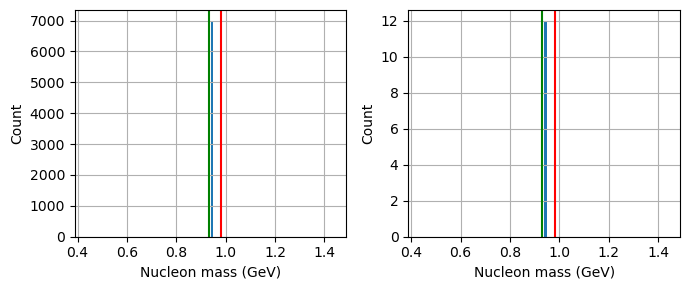

In [284]:
# Plot nucleon mass distribution
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].hist(M[nucleons["pdg"] > 1e5], bins=100)
axs[1].hist(M[nucleons["pdg"] < 1e5], bins=100)

for axs in axs:
    axs.set(xlabel="Nucleon mass (GeV)", ylabel="Count")
    axs.grid()
    axs.axvline(0.983, color="red")
    # Nucleon mass in the Oxygen nucleus
    axs.axvline(14.895082 / 16, color="green")

In [285]:
(nucleons["pdg"] < 1e5).sum()

12

## Resonance scattering

In [93]:
# Resonance scattering
# Delta mass
M_delta = 1.232 # GeV
# Delta width assuming dominance of S-waves
Gamma_Delta_0 = 0.12 # GeV
# Is 2 if the Delta produced is Delta++ (interaction with p), 
# and 2/3 if the Delta produced is Delta+ (interaction with n). 
# Maybe take average, since there are equally many n and p in Oxygen?
kappa = 2
M_V = np.sqrt(0.54) # GeV
C_V_3_0 = 2.05

C_0 = {4: -0.3, 5: 1.2}
a = -1.21
b = 2 # GeV^2
M_A = 1 # GeV


def K(zeta, x, w, j, k, n):
    functions = {
        (3, 3, 3): lambda zeta, x, w: -2 * zeta**3 * (1 - 2*x)**2 * w**2 + 2 * zeta * (2 - 3*x) * w,
        (3, 3, 4): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (3, 3, 5): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w + 2 * (1 + zeta),
        (3, 4, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 - zeta) * (1 - 2*x) * w,
        (3, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**2,
        (3, 4, 5): lambda zeta, x, w: zeta * (1 - 2*x) * w,
        (3, 5, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w**2 - 2 * (1 - zeta) * w,
        (3, 5, 4): lambda zeta, x, w: zeta * (1 - 2*x) * w**2,
        (3, 5, 5): lambda zeta, x, w: zeta * w
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def A(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 + 2 * (1 + zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * w**2,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 - (1 - zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**3 - (1 - zeta) * (1 - 4*x) * w**2,
        (1, 5, 5): lambda zeta, x, w: zeta * w**3 - (1 - zeta) * w**2,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 - 2 * (1 - zeta) * x * w,
        (2, 4, 5): lambda zeta, x, w: 4 * zeta * x * w**2 - 4 * (1 - zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x**2 * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * x * w**2 - 2 * (1 - zeta) * x * w,
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w - 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 - 2 * zeta * (2 - zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w**2 - zeta * (2 - zeta) * w,
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 - zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 - 2 * (1 - zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 + 2 * (1 - zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w**3 - zeta**2 * (1 - zeta) * w**2,
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**3 - 2 * zeta * (1 + zeta * (1 - zeta) * (1 - 2*x)) * w**2 + 2 * (1 - zeta) * w,
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 - zeta * (zeta * (1 - zeta) * (1 - 2*x)**2 - 2 * x) * w**2 - 2 * (1 - zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 - zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 4 * zeta * w**2 - 4 * (1 - zeta) * w,
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 + 4 * (1 - zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * w**2 - 2 * (1 - zeta) * w,
        (5, 5, 6): lambda zeta, x, w: 4 * zeta**3 * (1 - 2*x) * x * w**3 - 4 * zeta * (zeta * (1 - zeta) * (1 - 2*x) + 1) * x * w**2 + 4 * (1 - zeta) * x * w
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)


def V(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 - 2 * (1 - zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**2 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * w,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 + (1 + zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (1, 5, 5): lambda zeta, x, w: zeta * w + 1 + zeta,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 + zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 + 2 * (1 + zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w + 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 + 2 * zeta * (2 + zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w + zeta * (2 + zeta),
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 + zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 + 2 * (1 + zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 - 2 * (1 + zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta * (zeta * (1 + zeta) * (1 - 2*x) - 1) * w - 2 * (1 + zeta),
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (zeta * (1 + zeta) * (1 - 2*x)**2 + 2 * x) * w**2 + 2 * (1 + zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 + zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + x) * w + (1 + zeta)**2,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 + zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 + 2 * (1 + zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 - 4 * (1 + zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 2 * zeta**3 * w + 2 * zeta**2 * (1 + zeta),
        (5, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta**2 * (1 + zeta) * (1 - 2*x) * w
    }

    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def C_V(q, M, j):
    if j == 3:
        return C_V_3_0 / (1 - q**2 / M_V**2)**2
    if j == 4:
        return - M / M_delta * C_V(q, M, 3)
    if j > 4:
        return 0
    
def C_A(q, M, j):
    if j == 3:
        return 0
    if j == 6:
        return C_A(q, M, 5) * M**2 / (m_pi**2 - q**2)
    if j > 3:
        return C_0[j] * (1 - (a * q**2) / (b - q**2)) / (1 - q**2 / M_A**2)**2
    else:
        raise ValueError(f"Unsupported j = {j}")
    


def p_pi_star(W, M):
    return np.sqrt(((W**2 - M**2 + m_pi**2)/(2*W))**2 - m_pi**2)

def Gamma_Delta(W, M):
    return Gamma_Delta_0 * p_pi_star(W, M) / p_pi_star(M_delta, M)

def eta_delta_bw(W, M):
    return 1/(2*np.pi) * Gamma_Delta(W, M) / ((W**2 - M_delta**2)**2 + Gamma_Delta(W, M)**2/4)

def Wnres(x, Q2, p, q, M, n):
    # The invariant mass of the Delta particle. 
    # This should be a sample from a Breit-Wigner distribution 
    # around the central mass M_Delta and with width Gamma_Delta
    W = np.sqrt((p + q)**2)

    w_value = w(p, q, M)
    x = Q2 / (2*p.dot(q))
    zeta = M / M_delta

    if n == 3:
        return (
            2 * kappa * np.cos(theta_c)**2 * M * M_delta * 
            eta_delta_bw(W, M)**2 * 
            sum(
                K(zeta, x, w_value, j, k, n) * C_V(q, M, j) * C_A(q, M, k)
                for j, k in itertools.product(range(3, 7), repeat=2)
            )
        )
    
    return (
        kappa * np.cos(theta_c)**2 * M * M_delta * 
        eta_delta_bw(W, M)**2 * 
        sum(
            V(zeta, x, w_value, j, k, n) * C_V(q, M, j) * C_V(q, M, k) 
            + A(zeta, x, w_value, j, k, n) * C_A(q, M, j) * C_A(q, M, k) 
            for j, k in itertools.product(range(3, 7), repeat=2)
        )
    )



## Deep inelastic scattering

In [20]:
# Deep inelastic scattering
# The PDFs used in GENIE seems to bee CT10nlo, member 0 from LHAPDF. Source: https://github.com/GENIE-MC/Generator/blob/master/config/LHAPDF6.xml
# I should therefore probably use the same here
pdfset = lhapdf.mkPDF("CT10nlo", 0)
def pdf(quark, x, Q2):
    # TODO division by x might be wrong. Not sure
    f = pdfset.xfxQ2(quark, x, Q2) / x
    return np.array(f)


def mass_corrected_xi(x, Q2, charm):
    xi = x
    m_charm = 1.27 # GeV
    # If a charm quark is produced, replace x with xi
    xi[charm] = x[charm] / (Q2[charm] / (Q2[charm] + m_charm**2))
    # print(xi)
    return xi

def W1dis(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        # Correction, see eq. 55 in tau polarization paper. 
        (1 + xi/w(p, q, M)) * 
        np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F1
    )

def W2dis(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        1/w(p, q, M) 
        * 2 * np.sum([xi * pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F2
    )

def W3dis(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return 1/w(p, q, M) * 2 * (
        np.sum([pdf(quark, xi, Q2) for quark in range(1, 7)], axis=0)
        - np.sum([pdf(quark, xi, Q2) for quark in range(-6, 0)], axis=0)
    )

def W4dis(x, Q2, p, q, M, charm):
    return 0

def W5dis(x, Q2, p, q, M, charm):
    # In the tau polarization paper, there is a factor of 2 in front. 
    xi = mass_corrected_xi(x, Q2, charm)
    
    # I am not sure if this is a mistake, convention difference, or something else
    return 1/w(p, q, M) * np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # W1dis(x, Q2, p, q, M, charm) * 
# TODO something is wrong. Investigate

LHAPDF 6.5.4 loading /home/simon/miniconda3/envs/cern-skhep/share/LHAPDF/CT10nlo/CT10nlo_0000.dat
CT10nlo PDF set, member #0, version 4; LHAPDF ID = 11000


In [37]:
dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]
taus = dis_particles[dis_particles["pdg"] == 15]
nutaus = dis_particles.groupby("event_num").nth(1)
assert np.all(nutaus["pdg"] == 16)
nucleons = dis_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [38]:
nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon_mass = np.ones(nucleons.shape[0]) * 0.938919 #14.895082 / 16
nucleon_mass[nucleons["pdg"] < 1e5] = nucleons[nucleons["pdg"] < 1e5]["E"]
nucleon4m = vector.array({"E": nucleon_mass, "px": nucleons["px"], "py": nucleons["py"], "pz": nucleons["pz"]})

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

In [39]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))

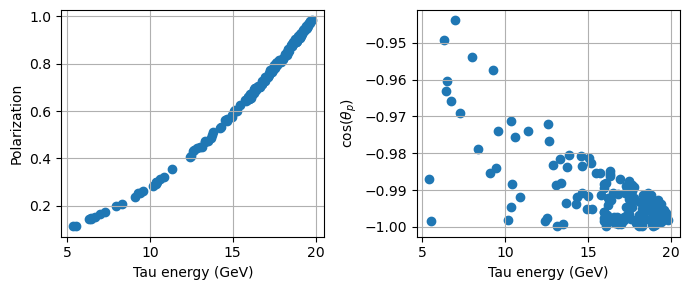

In [40]:
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for a in axs:
    a.grid()


The value is always within 0 and 1 for the left plot, while it is within -1 and 1 for the right plots, which is good.
However, for the left plot, there should be a dip and a discontinuity at around $E_\tau \approx 9$ GeV, after which the energy increases again. This is not the case here.

In [29]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost10deg_tau_events.iloc[x > 1] = False

s = np.array(polarization_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[almost10deg_tau_events].shape[0], dtype=bool))
))

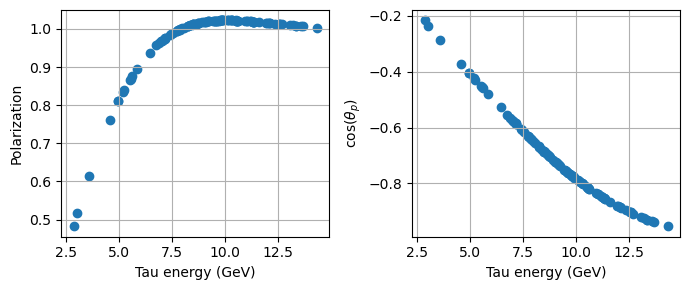

In [30]:
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for a in axs:
    a.grid()


The left plot should be almost constantly 1, with a very small dip around the middle. 

For the right plot, the curve should be a smooth transition from 1 to -1 from low energies ($E_\tau \approx 2$ GeV) to high energies ($E_\tau \approx 9$ GeV).

This is not what we see here. This can either be because of a bug in my code (though the formulas are not so complicated for DIS), or because the incorrect mass for the nucleon is used (will be fixed once I get W)

## Load my own GENIE events
For testing and evaluating W and Q2 values, I will use my own GENIE events.

In [69]:
import uproot

with uproot.open("../data/gntp.0.gst.root") as f:
    tree = f["gst"]
    qel = tree["qel"].array()
    res = tree["res"].array()
    dis = tree["dis"].array()
    cc = tree["cc"].array()
    taus = vector.array({"E": tree["El"].array(), "px": tree["pxl"].array(), "py": tree["pyl"].array(), "pz": tree["pzl"].array()})
    Q2 = tree["Q2s"].array()
    W = tree["Ws"].array()
    Ev = tree["Ev"].array()
    charm = tree["charm"].array()

nutaus = vector.array({"E": Ev, "px": np.zeros(len(Ev)), "py": np.zeros(len(Ev)), "pz": Ev})

In [70]:
q = nutaus - taus
M = -q.E + np.sqrt(W**2 + q.px**2 + q.py**2 + q.pz**2)

In [71]:
pd.Series(M[cc]).value_counts()

0.938272    252
1.877837    184
1.877837    174
1.877837    171
1.877837    168
           ... 
0.943217      1
0.824858      1
0.849733      1
0.894963      1
0.990134      1
Name: count, Length: 15984, dtype: int64

In [72]:
(Q2 / (2*q.E))[qel & cc]

<Array [0.836, 1.44, 1.05, ..., 0.986, 0.842, 1.29] type='3133 * float64'>

In [152]:
atan_angle = np.arctan(np.sqrt(taus.px **2 + taus.py**2) / taus.pz)
deltaangle = nutaus.deltaangle(taus)
assert np.allclose(np.arctan2(np.sqrt(taus.px**2 + taus.py**2), taus.pz), nutaus.deltaangle(taus))

vec2d = vector.array({"x": taus.pz, "y": np.sqrt(taus.px**2 + taus.py**2)})
assert np.allclose(vec2d.phi, deltaangle)

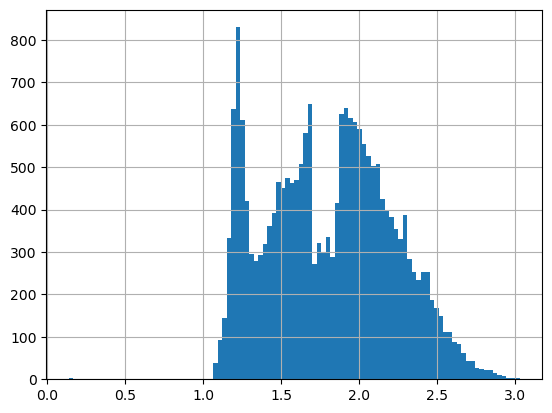

In [73]:
# W2 = (M + q.E)**2 - q.px**2 - q.py**2 - q.pz**2
plt.hist(W[cc], bins=100)
plt.grid()

In [74]:
np.sum(W > 2) / len(W)

0.50026

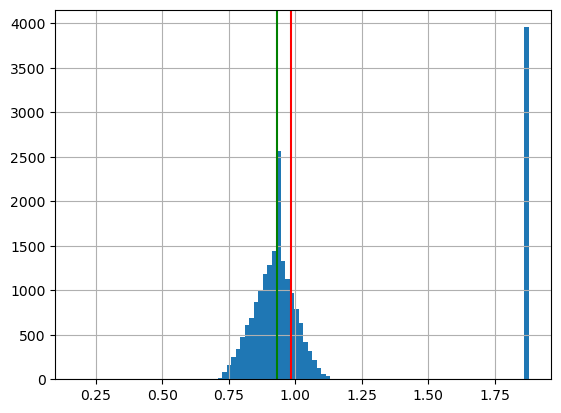

In [75]:
plt.hist(M[cc], bins=100)
plt.grid()
plt.axvline(0.983, c="r")
plt.axvline(14.895082 / 16, c="g")

In [77]:
np.sum(Q2 < 0)

12

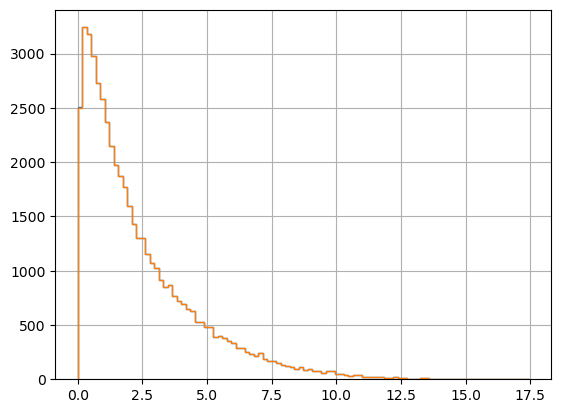

In [81]:
q2 = np.array(Q2)
q2[q2 < 0] = np.nan
plt.hist(-q**2, bins=100, histtype="step")
plt.hist(q2, bins=100, histtype="step")
plt.grid()

Q2s, Q2 and `-q**2` follow each other perfectly. This is a good cross-check. This means that I can safely use `-q**2` everywhere. 

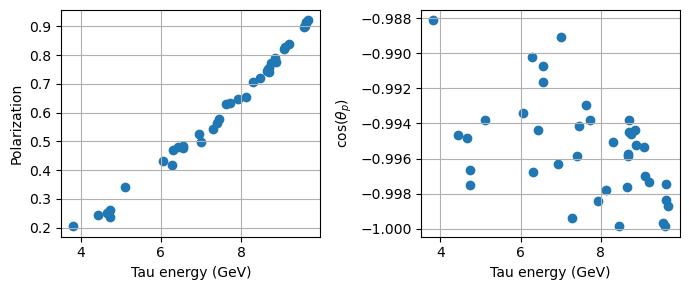

In [55]:
# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon4m = vector.array({"E": M, "px": np.zeros(len(M)), "py": np.zeros(len(M)), "pz": np.zeros(len(M))})
nutau4m = nutaus
tau4m = taus

q = nutau4m - tau4m
# Sanity checks
assert np.all((q**2) < 0)

tau_angles = np.arctan(np.sqrt(tau4m.px**2 + tau4m.py**2) / tau4m.pz)

zero_angle_tau_events = dis & cc & ((tau_angles * 180/np.pi) < 0.5)

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for a in axs:
    a.grid()


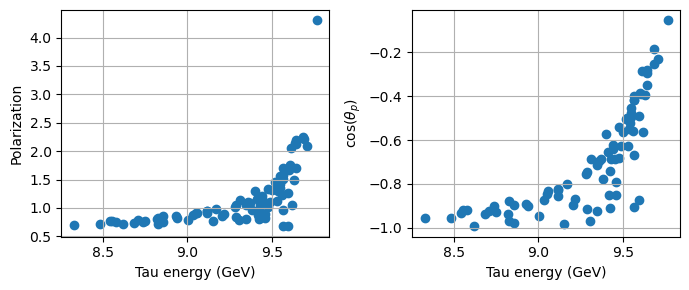

In [94]:
# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon4m = vector.array({"E": M, "px": np.zeros(len(M)), "py": np.zeros(len(M)), "pz": np.zeros(len(M))})
nutau4m = nutaus
tau4m = taus

q = nutau4m - tau4m
# Sanity checks
assert np.all((q**2) < 0)

tau_angles = np.arctan(np.sqrt(tau4m.px**2 + tau4m.py**2) / tau4m.pz)

zero_angle_tau_events = res & cc & ((tau_angles * 180/np.pi) < 1)

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "res",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


This plot looks just as weird. It is likely something wrong with the code.

## Old code

In [ ]:
def spin_vector(tau4m, nu4m, nucleon4m, int_type: str):
    # TODO check the code of this one with LaTeX, and manually, and fix if there are problems. Then run it and check values.
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2

    x = Q2 / (2*p.dot(q)) # Björken scaling variable

    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    else:
        raise NotImplementedError("Only qel implemented")
    
    F = (
        (2*W1 + mtau**2 / M**2 * W4) * (Etau - ptau * costheta)
        + W2 * (Etau + ptau * costheta)
        + W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
        + mtau**2 / M * W5
    )

    return (
        # sx component, in the tau-nu plane
        -mtau*np.sin(theta)/2 *
        (2*W1 - W2 + Enu / M * W3 - mtau**2/M**2 * W4 + Etau/M * W5)
        / F,
        # sz component
        -1/2 * (
            (2*W1 - mtau**2 / M**2 * W4) * (ptau - Etau * costheta)
            + W2 * (ptau + Etau * costheta)
            + W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
            - mtau**2 / M * W5 * costheta
        ) / F
    )